# Microwave frequency selective surface (FSS)

A Frequency Selective Surface (FSS) is a type of electromagnetic structure that allows certain frequencies to pass through while reflecting or blocking other frequencies. It is composed of a periodic array of conductive or dielectric elements that are spaced apart at a distance that is much smaller than the wavelength of the electromagnetic radiation. The FSS can be designed to selectively filter and manipulate the electromagnetic waves that pass through it based on the geometry, spacing, and material properties of its constituent elements. It is often used as a passive component in microwave and millimeter-wave devices, such as antennas, radars, filters, and absorbers.

This notebook provides a demonstration of a microwave FSS composed of copper cross structures. Due to its very thin copper layer (0.1 mm) compared to the wavelength (~2.5 cm), we model the copper layer as a 2D surface conductivity to ensure computational efficiency. The FSS has been designed to exhibit a stop band at 12 GHz, where the transmission (S21) reaches as low as -50 dB. By visualizing the field distribution at the resonant frequency, we can observe the dipolar resonance feature of the copper structure. This simulation showcases the effectiveness of FSSs as passive components in microwave devices, and their ability to manipulate electromagnetic waves with high precision.

<img src="img/frequency_selective_surface.png" width="500">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

[08:43:00] WARNING: This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on PyPI.   ]8;id=996351;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=463274;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\
           Future releases will be uploaded to the 'tidy3d' repository. From now on, please use 'pip               
           install tidy3d' instead.                                                                                

           INFO: Using client version: 1.10.0rc2                                                          ]8;id=900217;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=987414;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

## Simulation Setup

The default frequency unit in `Tidy3D` is Hz. For convenience, we prefer to work with GHz in this example. A frequency range from 10 GHz to 14 GHz is studied while the FSS is designed to resonate at 12 GHz.

In [2]:
GHz = 1e9  # 1 GHz = 1e9 Hz

freq0 = 12 * GHz  # central frequency
freqs = np.linspace(10, 14, 500) * GHz  # frequency range of interest

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source spectrum

lda0 = td.C_0 / freq0  # central wavelength

The default length unit in Tidy3D is $\mu m$. For convenience, we prefer to work with mm in this example. Here we define the geometric parameters such as the length and width of the cross structure.

In [3]:
mm = 1e3  # 1 mm = 1e3 um
P = 15 * mm  # periodicity of the unit cell
L = 9.4 * mm  # length of the cross
W = 2 * mm  # width of the cross
t_sub = 2.2 * mm  # thickness of the substrate
t_copper = 0.1 * mm  # thickness of the copper layer

Since the copper layer is very thin, we model it as a [Medium2D](../_autosummary/tidy3d.Medium2D.html) instead of a regular [Medium](../_autosummary/tidy3d.Medium.html). This way, we do not need to use a very fine grid to resolve the actual thickness of the copper layer. The conductivity of copper is about $5\times 10^7$ S/m, which is 50 S/$\mu m$. We use the `from_medium` method to construct a [Medium2D](../_autosummary/tidy3d.Medium2D.html) from a regular [Medium](../_autosummary/tidy3d.Medium.html).

In [4]:
sigma_copper = 50  # copper conductivity in S/um
copper = td.Medium2D.from_medium(
    td.Medium(conductivity=sigma_copper), thickness=t_copper
)  # define copper as a Medium2D

eps_sub = 2.5  # permittivity of the substrate
sub_medium = td.Medium(permittivity=eps_sub)  # define substrate medium

Next, we define the [Structures](../_autosummary/tidy3d.Structure.html). [Medium2D](../_autosummary/tidy3d.Medium2D.html) can only be applied to geometry with zero thickness in one of the dimensions.

In [5]:
cross = []
cross.append(
    td.Structure(
        geometry=td.Box.from_bounds(rmin=(-L / 2, -W / 2, t_sub), rmax=(L / 2, W / 2, t_sub)),
        medium=copper,
    )
)
cross.append(
    td.Structure(
        geometry=td.Box.from_bounds(rmin=(-W / 2, -L / 2, t_sub), rmax=(W / 2, L / 2, t_sub)),
        medium=copper,
    )
)

substrate = td.Structure(
    geometry=td.Box(center=(0, 0, t_sub / 2), size=(td.inf, td.inf, t_sub)), medium=sub_medium
)

A [PlaneWave](../_autosummary/tidy3d.PlaneWave.html) source polarized in the x direction is added as the incident wave from the top of the FSS. To measure reflection (S11) and transmission (S21), two [FluxMonitors](../_autosummary/tidy3d.FluxMonitor.html) are added on the top and bottom of the simulation domain. Lastly, to visualize the resonant mode field, a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) is added to the copper layer plane.

In [6]:
offset = lda0 / 2  # extra spacing added in the positive and negative z directions

# define a plane wave source
plane_wave = td.PlaneWave(
    center=(0, 0, t_sub + 0.1 * offset),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
)

# define a flux monitor to measure reflection
S11_monitor = td.FluxMonitor(
    center=(0, 0, t_sub + offset),
    size=(td.inf, td.inf, 0),
    freqs=freqs,
    name="S11",
)

# define a flux monitor to measure reflection
S21_monitor = td.FluxMonitor(
    center=(0, 0, -t_sub - offset),
    size=(td.inf, td.inf, 0),
    freqs=freqs,
    name="S21",
    normal_dir="-",
)

# define a field monitor to visualize field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, t_sub), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

With the previously defined structures, source, and monitors, we are ready to define a `Tidy3D` [Simulation](../_autosummary/tidy3d.Simulation.html). Periodic boundary condition is applied in the $x$ and $y$ directions while [PML](../_autosummary/tidy3d.PML.html) is applied in the $z$ direction. 

We also set up automatic nonuniform grids. In addition, we use a mesh override structure around the FFS unit cell to further refine the grids.

In [7]:
# simulation domain size in z
Lz = t_sub + 2.2 * offset

# define a BoundarySpec
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary(minus=td.PML(), plus=td.PML()),
)

# define a mesh override structure
refine_box = td.Structure(
    geometry=td.Box(center=(0, 0, t_sub / 2), size=(td.inf, td.inf, 2*t_sub)), medium=td.Medium(permittivity=5**2)
)

# define a GridSpec
grid_spec = td.GridSpec.auto(min_steps_per_wvl=100, wavelength=lda0, override_structures=[refine_box])

run_time = 1e-8  # simulation run time

# define simulation
sim = td.Simulation(
    size=(P, P, Lz),
    grid_spec=grid_spec,
    structures=[substrate] + cross,
    sources=[plane_wave],
    monitors=[S11_monitor, S21_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=boundary_spec,
    symmetry=(-1, 1, 0),  # symmetry is used to reduce the computational load
)

Before submitting the simulation job to the server, we can validate the simulation setup by plotting it. Here we overlay the grids on top to make sure the grid is sufficiently fine compared to the structure sizes.

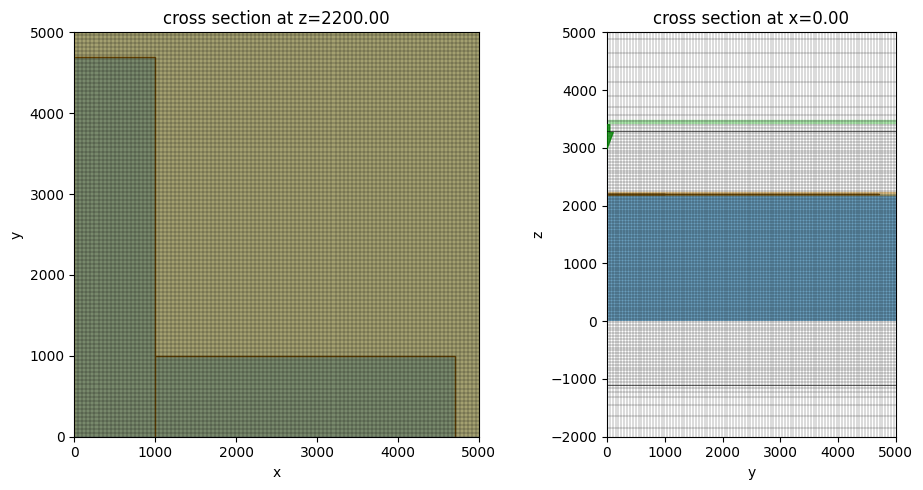

In [8]:
f, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
sim.plot(z=t_sub, ax=ax[0])
sim.plot_grid(z=0, ax=ax[0])
ax[0].set_xlim(0,5000)
ax[0].set_ylim(0,5000)

sim.plot(x=0, ax=ax[1])
sim.plot_grid(x=0, ax=ax[1]);
ax[1].set_xlim(0,5000)
ax[1].set_ylim(-2000,5000);

Submit the simulation job to the server.

In [9]:
job = web.Job(simulation=sim, task_name="frequency_selective_surface")
sim_data = job.run(path="data/simulation_data.hdf5")

[08:43:01] INFO: Created task 'frequency_selective_surface' with task_id                                  ]8;id=832177;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=515282;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\
           'fdve-9dc5bba0-4b40-43d8-ad09-74bdd2ce9e4cv1'.                                                          

Output()

[08:43:03] INFO: status = queued                                                                          ]8;id=639942;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=167982;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

Output()

[08:43:08] INFO: status = preprocess                                                                      ]8;id=710117;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=515854;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

[08:43:12] INFO: Maximum FlexUnit cost: 0.201. Use 'web.real_cost(task_id)' to get the billed FlexUnit    ]8;id=896263;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=305558;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\
           cost after a simulation run.                                                                            

           INFO: starting up solver                                                                       ]8;id=839171;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=609067;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

           INFO: running solver                                                                           ]8;id=555390;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=550774;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

Output()

[08:44:03] INFO: early shutoff detected, exiting.                                                         ]8;id=304812;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=4970;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

           INFO: status = postprocess                                                                     ]8;id=631596;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=545933;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

Output()

[08:44:07] INFO: status = success                                                                         ]8;id=974696;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=80088;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

Output()

[08:44:09] INFO: loading SimulationData from data/simulation_data.hdf5                                    ]8;id=351231;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=959006;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

## Result Visualization 

After the simulation is complete, we first visualize the S-parameters. A prominent resonance feature is observed at 12 GHz where S21 reaches -50 dB. 

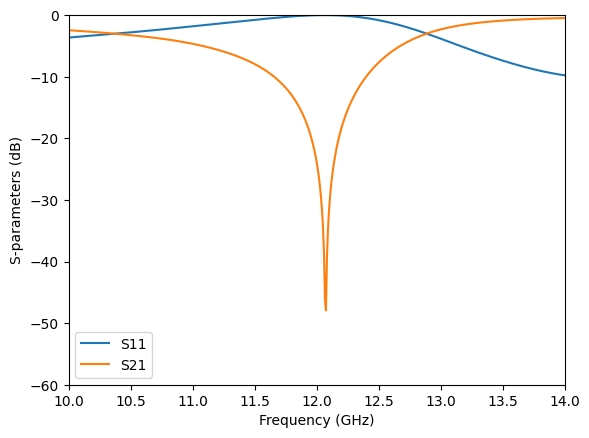

In [10]:
S11 = sim_data["S11"].flux
S21 = sim_data["S21"].flux

plt.plot(freqs / GHz, 10 * np.log10(S11), label="S11")
plt.plot(freqs / GHz, 10 * np.log10(S21), label="S21")
plt.xlim(10, 14)
plt.ylim(-60, 0)
plt.xlabel("Frequency (GHz)")
plt.ylabel("S-parameters (dB)")
plt.legend();

Lastly, we plot the field intensity distribution at the resonant frequency. A strong dipolar field pattern is observed in the horizontal copper pattern. This dipolar resonance is responsible for the total reflection of the electromagnetic wave at this frequency.

           WARNING: Evaluating permittivity of a 'Medium2D' is unphysical.                                ]8;id=734422;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py\log.py]8;;\:]8;id=487080;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\log.py#57\57]8;;\

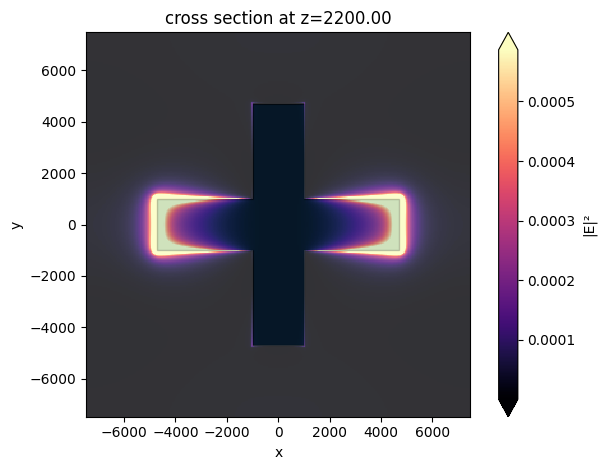

In [11]:
sim_data.plot_field("field", 'E', "abs^2");